In [1]:
from keras.models import Model, Sequential
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, GRU, Embedding, Conv1D, MaxPooling1D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import requests
import cv2
from keras import layers

Using TensorFlow backend.


# Autoencoder

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# data normalization
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 666)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

(42000, 28, 28, 1)
(18000, 28, 28, 1)
(42000, 10)
(18000, 10)


In [0]:
# encoding
input_img = Input(shape = (28, 28, 1))

x1 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(input_img) #28*28*32
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size = (2, 2))(x1) # 14*14*32
x2 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x1) # 14*14*64
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size = (2, 2))(x2) # 7*7*64
x3 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(x2) # 7*7*128
x3 = BatchNormalization()(x3)
x4 = Conv2D(2, (3, 3), activation = "relu", padding = "same")(x3) # 7*7*256
encoded = BatchNormalization()(x4)

In [0]:
# decoding
x5 = Conv2D(4, (3, 3), activation = "relu", padding = "same")(encoded) #7*7*128
x5 = BatchNormalization()(x5)
x6 = Conv2D(8, (3, 3), activation = "relu", padding = "same")(x5) #7*7*64
x6 = BatchNormalization()(x6)
x6 = UpSampling2D(size = (2, 2))(x6) #14*14*64
x7 = Conv2D(16, (3, 3), activation = "relu", padding = "same")(x6)
x7 = BatchNormalization()(x7)
x7 = UpSampling2D(size = (2, 2))(x7) #28*28*32
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x7)

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [0]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/5
42000/42000 [==============================] - 77s 2ms/step - loss: 0.0443 - val_loss: 0.0312
Epoch 2/5
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0250 - val_loss: 0.0329
Epoch 3/5
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0211 - val_loss: 0.0231
Epoch 4/5
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 5/5
42000/42000 [==============================] - 76s 2ms/step - loss: 0.0176 - val_loss: 0.0176


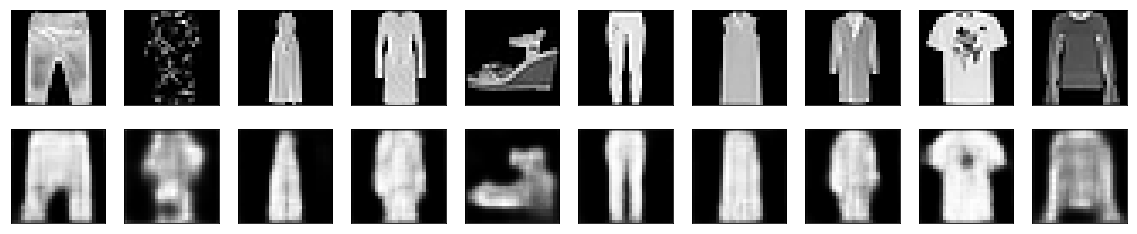

In [0]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Iamge Classification

## Deep CNN

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = "relu", padding = "same", input_shape = (28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = "relu", padding = "same"))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(10, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adadelta", metrics = ["accuracy"])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
__________

At first convolution 2D layer, there are 32 kernels (3x3 kernel shape) which will result in 32 Feature Maps output.
padding = "same" means that the output array has the same shape as the input. 
Since input shape is (28,28,1), the first output shape is (28, 28, 32). Total 320 (32*10) parameters are trained.
At first MaxPooling 2D layer, 2*2 MaxPool will give us the output shape (14, 14, 32) 
At second convolution 2D layer, there are 64 kernels (3x3 kernel shape) which will result in 64 Feature Maps output.
Output Shape is (14, 14, 64), total 18496 parameters are trained.
At second MaxPooling 2D layer, 2*2 MaxPool will give us the output shape (7, 7, 64)
At last convolution 2D layer, 128 kernals result in 128 output feature map (7, 7, 128), total 73856 parameters are trained. 
Flatten tensor into vector, total (6272*128) + 128 = 802944 parameters are trained
Final classification with dense layer, all parameters are trained. 

In [0]:
train_model = model.fit(x_train, y_train, 
                        epochs = 10, batch_size = 128, 
                        verbose = 1, validation_data = (x_test, y_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 51s 1ms/step - loss: 0.6129 - acc: 0.7756 - val_loss: 0.4585 - val_acc: 0.8189
Epoch 2/10
42000/42000 [==============================] - 50s 1ms/step - loss: 0.3480 - acc: 0.8747 - val_loss: 0.3419 - val_acc: 0.8756
Epoch 3/10
42000/42000 [==============================] - 51s 1ms/step - loss: 0.2860 - acc: 0.8956 - val_loss: 0.4541 - val_acc: 0.8520
Epoch 4/10
42000/42000 [==============================] - 50s 1ms/step - loss: 0.2521 - acc: 0.9085 - val_loss: 0.3741 - val_acc: 0.8583
Epoch 5/10
42000/42000 [==============================] - 50s 1ms/step - loss: 0.2218 - acc: 0.9189 - val_loss: 0.4137 - val_acc: 0.8620
Epoch 6/10
42000/42000 [==============================] - 50s 1ms/step - loss: 0.1990 - acc: 0.9267 - val_loss: 0.2391 - val_acc: 0.9108
Epoch 7/10
42000/42000 [==============================] - 50s 1ms/step - loss: 0.1797 - acc: 0.9329 - val_loss: 0.2412 - val_acc

In [0]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3559369967314932
Test accuracy: 0.8936666666666667


## Transfer Lenarning

In [2]:
# Preprocessing the input 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 789)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train = np.asarray([cv2.resize(x, (48,48)) for x in x_train])
x_test = np.asarray([cv2.resize(x, (48,48)) for x in x_test])
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_train = x_train.repeat(3, axis = -1)
x_test = x_test.repeat(3, axis = -1)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

4423680/4422102 [==============================] - 1s 0us/step


((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [3]:
x_train = preprocess_input(x_train)
x_test  = preprocess_input(x_test)

# Create the base model of VGG16
vgg16 = VGG16(weights = "imagenet", include_top = False, input_shape = (48, 48, 3))

58892288/58889256 [==============================] - 7s 0us/step


In [4]:
# Extracting features
train_features = vgg16.predict(x_train, batch_size=16, verbose=1)
test_features = vgg16.predict(x_test, batch_size=16, verbose=1)

12000/12000 [==============================] - 303s 25ms/step


In [0]:
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (12000, 1*1*512))

In [0]:
model_tl = Sequential()
model_tl.add(Dense(512, activation='relu', input_dim=(1*1*512)))
model_tl.add(Dense(10, activation='softmax'))

In [12]:
vgg16.trainable = False
model_tl.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(512, 512) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>]

In [13]:
model_tl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 267,786
Trainable params: 267,786
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_tl.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["acc"])

In [16]:
model_tl.fit(train_features_flat, y_train, 
             batch_size = 128, epochs = 20, 
             validation_data = (test_features_flat, y_test), verbose = 1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 3s 61us/step - loss: 1.3428 - acc: 0.4993 - val_loss: 1.2311 - val_acc: 0.5775
Epoch 2/20
48000/48000 [==============================] - 3s 63us/step - loss: 1.2039 - acc: 0.5622 - val_loss: 1.1306 - val_acc: 0.5922
Epoch 3/20
48000/48000 [==============================] - 3s 65us/step - loss: 1.1095 - acc: 0.5981 - val_loss: 1.1142 - val_acc: 0.5981
Epoch 4/20
48000/48000 [==============================] - 3s 66us/step - loss: 1.0485 - acc: 0.6233 - val_loss: 1.0448 - val_acc: 0.6248
Epoch 5/20
48000/48000 [==============================] - 3s 63us/step - loss: 1.0004 - acc: 0.6387 - val_loss: 0.9736 - val_acc: 0.6421
Epoch 6/20
48000/48000 [==============================] - 3s 62us/step - loss: 0.9621 - acc: 0.6532 - val_loss: 0.9260 - val_acc: 0.6691
Epoch 7/20
48000/48000 [==============================] - 3s 62us/step - loss: 0.9381 - acc: 0.6643 - val_loss: 0.8966 - val_acc

In [20]:
tl_test = model_tl.evaluate(test_features_flat, y_test, verbose = 0)
print("Test loss:", tl[0])
print("Test accuracy:", tl[1])

Test loss: 0.7782880609035492
Test accuracy: 0.7118333333333333


# Text Classification
## RNN

In [0]:
url_b = requests.get("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt").text.split("\n")
url_m = requests.get("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt").text.split("\n")
url_b = [x for x in url_b if x[0] != "#"]
X_train = np.asarray(url_b + url_m)
Y_train = np.concatenate((np.ones(len(url_b)), np.zeros(len(url_m))))
print(len(url_b))
print(len(url_m))
tokenizer = Tokenizer(char_level = True)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train, mode = "count")
print(X_train.shape)
maxlen = X_train.shape[1]

66015
1297
(67312, 42)


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 1234)

In [0]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim = 100, output_dim = 32, input_length = maxlen))
model_rnn.add(GRU(32))
model_rnn.add(Dense(1, activation = "sigmoid"))
model_rnn.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["acc"])

In [0]:
model_rnn.fit(X_train, Y_train, epochs = 5, batch_size = 128, validation_data = (X_test, Y_test), verbose = 1)

Train on 47118 samples, validate on 20194 samples
Epoch 1/5
47118/47118 [==============================] - 70s 1ms/step - loss: 0.1050 - acc: 0.9814 - val_loss: 0.0956 - val_acc: 0.9792
Epoch 2/5
47118/47118 [==============================] - 66s 1ms/step - loss: 0.0682 - acc: 0.9814 - val_loss: 0.0613 - val_acc: 0.9792
Epoch 3/5
47118/47118 [==============================] - 66s 1ms/step - loss: 0.0560 - acc: 0.9814 - val_loss: 0.0595 - val_acc: 0.9792
Epoch 4/5
47118/47118 [==============================] - 65s 1ms/step - loss: 0.0551 - acc: 0.9814 - val_loss: 0.0587 - val_acc: 0.9792
Epoch 5/5
47118/47118 [==============================] - 69s 1ms/step - loss: 0.0547 - acc: 0.9814 - val_loss: 0.0584 - val_acc: 0.9792


In [0]:
score_rnn = model_rnn.evaluate(X_test, Y_test, verbose = 0)
print("Test loss:", score_rnn[0])
print("Test accuracy:", score_rnn[1])

Test loss: 0.0583514247186
Test accuracy: 0.979152223433


## CNN

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim = 100, output_dim = 32, input_length = maxlen))
model_cnn.add(Conv1D(256, 3, activation = "relu"))
model_cnn.add(MaxPooling1D(3))
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation = "relu"))
model_cnn.add(Dense(1, activation = "sigmoid"))
model_cnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["acc"])

In [0]:
model_cnn.fit(X_train, Y_train, batch_size = 128, epochs = 5, validation_data = (X_test, Y_test))

Train on 47118 samples, validate on 20194 samples
Epoch 1/5
47118/47118 [==============================] - 253s 5ms/step - loss: 0.0638 - acc: 0.9790 - val_loss: 0.0414 - val_acc: 0.9825
Epoch 2/5
47118/47118 [==============================] - 254s 5ms/step - loss: 0.0346 - acc: 0.9856 - val_loss: 0.0395 - val_acc: 0.9838
Epoch 3/5
47118/47118 [==============================] - 252s 5ms/step - loss: 0.0314 - acc: 0.9868 - val_loss: 0.0343 - val_acc: 0.9865
Epoch 4/5
47118/47118 [==============================] - 252s 5ms/step - loss: 0.0306 - acc: 0.9877 - val_loss: 0.0339 - val_acc: 0.9871
Epoch 5/5
47118/47118 [==============================] - 252s 5ms/step - loss: 0.0283 - acc: 0.9886 - val_loss: 0.0333 - val_acc: 0.9871


In [0]:
score_cnn = model_cnn.evaluate(X_test, Y_test, verbose = 0)
print("Test loss:", score_cnn[0])
print("Test accuracy:", score_cnn[1])

Test loss: 0.0332764909487
Test accuracy: 0.987124888581


## Compare RNN & CNN

In [0]:
Y_rnn = model_rnn.predict(X_test).ravel()
Y_cnn = model_cnn.predict(X_test).ravel()
fpr_r, tpr_r, thresholds_r = roc_curve(Y_test, Y_rnn)
auc_r = auc(fpr_r, tpr_r)
fpr_c, tpr_c, thresholds_c = roc_curve(Y_test, Y_cnn)
auc_c = auc(fpr_c, tpr_c)

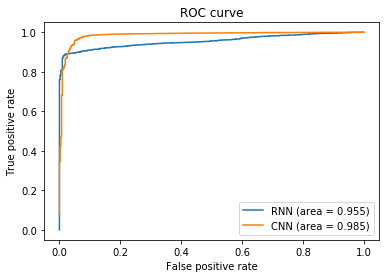

In [0]:
plt.figure(1)
plt.plot(fpr_r, tpr_r, label='RNN (area = {:.3f})'.format(auc_r))
plt.plot(fpr_c, tpr_c, label='CNN (area = {:.3f})'.format(auc_c))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()